AutoGluon - Predicción de ventas (tn) por producto para febrero 2020

In [1]:
# 📦 1. Importar librerías
import pandas as pd
import os
import duckdb
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

In [13]:
# 📄 2. Cargar datasets desde DuckDB

# Conectar a la base de datos DuckDB
db_path = '../input/db/labo3.duckdb'
con = duckdb.connect(database=db_path, read_only=True)

# Consultar la tabla ventas_features_final
df_sellin = con.execute("""
    SELECT *
    FROM ventas_features_final
    WHERE product_id in (select product_id from tb_productos_a_predecir)                    
""").fetchdf()
print(f"Datos de ventas_features_final cargados: {df_sellin.shape}")

# Cargar datos de productos
df_productos = pd.read_csv("../input/tb_productos.txt", sep="\t")
print(f"Datos de productos cargados: {df_productos.shape}")

con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Datos de ventas_features_final cargados: (12254054, 98)
Datos de productos cargados: (1251, 7)


In [ ]:
# 📄 Leer lista de productos a predecir
"""
with open("../input/tb_productos_a_predecir.txt", "r") as f:
    product_ids = [int(line.strip()) for line in f if line.strip().isdigit()]
print(f"Productos a predecir: {len(product_ids)}")
"""

Productos a predecir: 780


In [14]:
# 🧹 3. Preprocesamiento
# Convertir periodo a datetime
df_sellin['timestamp'] = pd.to_datetime(df_sellin['periodo'], format='%Y%m')
display(df_sellin.head())

,key_producto_cliente,antiguedad_cliente,antiguedad_producto,cust_request_qty,cust_request_tn,customer_id,key_customer_producto_periodo,key_periodo_customer_producto,key_periodo_producto,periodo,...,ratio_vs_promedio_otros_productos_cliente,stddev_historico_mes,tn_total_cliente_periodo,tn_total_producto_periodo,cat1,cat2,cat3,brand,sku_size,timestamp
0,20090|10170,0,0,1.0,0.41496,10170,10170|20090|201701,201701|10170|20090,201701|20090,201701,...,134.309062,0.863808,2.75378,59.54684,FOODS,SOPAS Y CALDOS,Caldo Cubo,MAGGI,12,2017-01-01
1,20091|10170,0,0,0.0,0.00000,10170,10170|20091|201701,201701|10170|20091,201701|20091,201701,...,0.000000,0.000000,2.75378,105.89790,HC,ROPA LAVADO,Polvo,ROPEX1,400,2017-01-01
2,20092|10170,0,0,0.0,0.00000,10170,10170|20092|201701,201701|10170|20092,201701|20092,201701,...,0.000000,0.000000,2.75378,138.07521,HC,HOGAR,Cremoso,MUSCULO,750,2017-01-01
3,20093|10170,0,0,0.0,0.00000,10170,10170|20093|201701,201701|10170|20093,201701|20093,201701,...,0.000000,0.000000,2.75378,98.02611,PC,PIEL2,Jabon Regular,DEOS1,375,2017-01-01
4,20094|10170,0,0,0.0,0.00000,10170,10170|20094|201701,201701|10170|20094,201701|20094,201701,...,0.000000,0.000000,2.75378,112.35975,PC,CABELLO,ACONDICIONADOR,SHAMPOO2,930,2017-01-01


In [ ]:
# Filtrar hasta dic 2019 y productos requeridos
"""
df_filtered = df_sellin[
    (df_sellin['timestamp'] <= '2019-12-01') &
    (df_sellin['product_id'].isin(product_ids))
]
print(f"Datos filtrados: {df_filtered.shape}")
"""

Datos filtrados: (12254054, 99)


In [15]:
# Agregar tn por periodo, cliente y producto
df_grouped = df_sellin.groupby(['timestamp', 'customer_id', 'product_id'], as_index=False)['tn'].sum()
print(f"Datos agrupados: {df_grouped.shape}")
display(df_grouped.head())

Datos agrupados: (12254054, 4)


,timestamp,customer_id,product_id,tn
0,2017-01-01,10001,20001,99.43861
1,2017-01-01,10001,20002,87.64856
2,2017-01-01,10001,20003,100.21284
3,2017-01-01,10001,20004,21.73954
4,2017-01-01,10001,20005,0.00000


In [16]:
# Agregar tn total por periodo y producto
df_monthly_product = df_grouped.groupby(['timestamp', 'product_id'], as_index=False)['tn'].sum()
print(f"Datos mensuales por producto: {df_monthly_product.shape}")
display(df_monthly_product.head())

Datos mensuales por producto: (22375, 3)


,timestamp,product_id,tn
0,2017-01-01,20001,934.77222
1,2017-01-01,20002,550.15707
2,2017-01-01,20003,1063.45835
3,2017-01-01,20004,555.91614
4,2017-01-01,20005,494.27011


In [17]:
# Agregar columna 'item_id' para AutoGluon
df_monthly_product['item_id'] = df_monthly_product['product_id']
display(df_monthly_product.head())

,timestamp,product_id,tn,item_id
0,2017-01-01,20001,934.77222,20001
1,2017-01-01,20002,550.15707,20002
2,2017-01-01,20003,1063.45835,20003
3,2017-01-01,20004,555.91614,20004
4,2017-01-01,20005,494.27011,20005


In [62]:
# ⏰ 4. Crear TimeSeriesDataFrame

# Agregar columnas numéricas adicionales
NUMERIC_COLS = [
    'ma_tn_12m',
    'ma_tn_3m',
    'ma_tn_6m',
    'promedio_historico_mes'
]

# Calcular el promedio de las columnas numéricas por producto y timestamp
df_numeric_temporal = df_sellin.groupby(['product_id', 'timestamp'], as_index=False)[NUMERIC_COLS].mean()

# Agregar las columnas numéricas al DataFrame temporal principal
df_monthly_product_with_features = df_monthly_product.merge(
    df_numeric_temporal,
    on=['product_id', 'timestamp'],
    how='left'
)

# Agregar columna 'item_id' para AutoGluon
df_monthly_product_with_features['item_id'] = df_monthly_product_with_features['product_id']

# Solo características categóricas como static features (no cambian en el tiempo)
#static_features = df_productos[['product_id', 'brand', 'cat1', 'cat2', 'cat3']].rename(columns={'product_id': 'item_id'})

# Crear TimeSeriesDataFrame con las características numéricas temporales incluidas
ts_data = TimeSeriesDataFrame.from_data_frame(
    df_monthly_product_with_features,
    id_column='item_id',
    timestamp_column='timestamp',
    #static_features_df=static_features
)

display(ts_data.head())
#display(ts_data.static_features.head())

,,product_id,tn,ma_tn_12m,ma_tn_3m,ma_tn_6m,promedio_historico_mes
item_id,timestamp,,,,,,
20001,2017-01-01,20001,934.77222,2.158827,2.158827,2.158827,2.578151
20002,2017-01-01,20002,550.15707,1.270571,1.270571,1.270571,2.142621
20003,2017-01-01,20003,1063.45835,2.456024,2.456024,2.456024,2.241212
20004,2017-01-01,20004,555.91614,1.283871,1.283871,1.283871,1.133707
20005,2017-01-01,20005,494.27011,1.141501,1.141501,1.141501,0.976773


In [63]:
# Análisis de valores nulos por columna
null_values = ts_data.isnull().sum()
print("🔍 Análisis de Valores Nulos por Columna:")
print("="*50)
for col, nulls in null_values.items():
    percentage = (nulls / len(ts_data)) * 100
    print(f"   {col:<20}: {nulls:>3} nulos ({percentage:>5.1f}%)")
print("="*50)

# Completar valores faltantes
#ts_data = ts_data.fill_missing_values()

🔍 Análisis de Valores Nulos por Columna:
   product_id          :   0 nulos (  0.0%)
   tn                  :   0 nulos (  0.0%)
   ma_tn_12m           :   0 nulos (  0.0%)
   ma_tn_3m            :   0 nulos (  0.0%)
   ma_tn_6m            :   0 nulos (  0.0%)
   promedio_historico_mes:   0 nulos (  0.0%)


In [ ]:
# ⚙️ 5. Definir y entrenar predictor
# prediction_length: número de periodos futuros a predecir (aquí 2 meses: enero y febrero 2020)
# target: nombre de la columna objetivo a predecir, en este caso 'tn'
# freq: frecuencia temporal de los datos, 'MS' significa "Month Start" (inicio de mes)
predictor = TimeSeriesPredictor(
    prediction_length=2,
    target='tn',
    freq='MS',  # Frecuencia mensual (Month Start),
    #eval_metric='MAE',
    quantile_levels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    cache_predictions=True,
          
)

predictor.fit(ts_data,
              num_val_windows=3, 
              time_limit=60*60*2,
              enable_ensemble=True,
              #val_step_size=1,
              refit_full=True
              )

No path specified. Models will be saved in: "AutogluonModels\ag-20250811_020838"
Beginning AutoGluon training... Time limit = 7200s
AutoGluon will save models to 'c:\proyectos\labo3-2025r\scripts\AutogluonModels\ag-20250811_020838'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.0
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
CPU Count:          20
GPU Count:          1
Memory Avail:       14.42 GB / 31.73 GB (45.5%)
Disk Space Avail:   239.48 GB / 531.97 GB (45.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAE,
 'freq': 'MS',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': True,
 'skip_model_selection': False,
 'target': 'tn',
 'time_limit': 7200,
 'verbosity': 2}

Provided tra

In [101]:
predictor.leaderboard(ts_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-7.786042,-9.736091,11.547088,3.011029,0.818910,13
1,WeightedEnsemble_FULL,-7.788630,NaN,3.927095,NaN,0.818910,26
2,TemporalFusionTransformer_FULL,-7.946975,NaN,0.375408,NaN,122.286392,22
3,TemporalFusionTransformer,-7.946975,-10.003036,0.340457,0.211168,245.690763,9
4,ChronosFineTuned[bolt_small]_FULL,-8.394754,NaN,0.409252,NaN,60.182921,21
5,ChronosFineTuned[bolt_small],-8.394754,-10.663414,0.556056,0.056207,182.087617,8
6,DeepAR,-8.659473,-10.338224,0.510561,0.310776,266.042494,10
7,DeepAR_FULL,-8.679469,NaN,0.699703,NaN,70.070584,23
8,ChronosZeroShot[bolt_base]_FULL,-9.500956,NaN,1.871015,NaN,0.003000,20
9,ChronosZeroShot[bolt_base],-9.500956,-11.227272,1.611784,1.625188,3.907636,7


In [102]:
# 🔮 6. Generar predicción
forecast = predictor.predict(ts_data)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


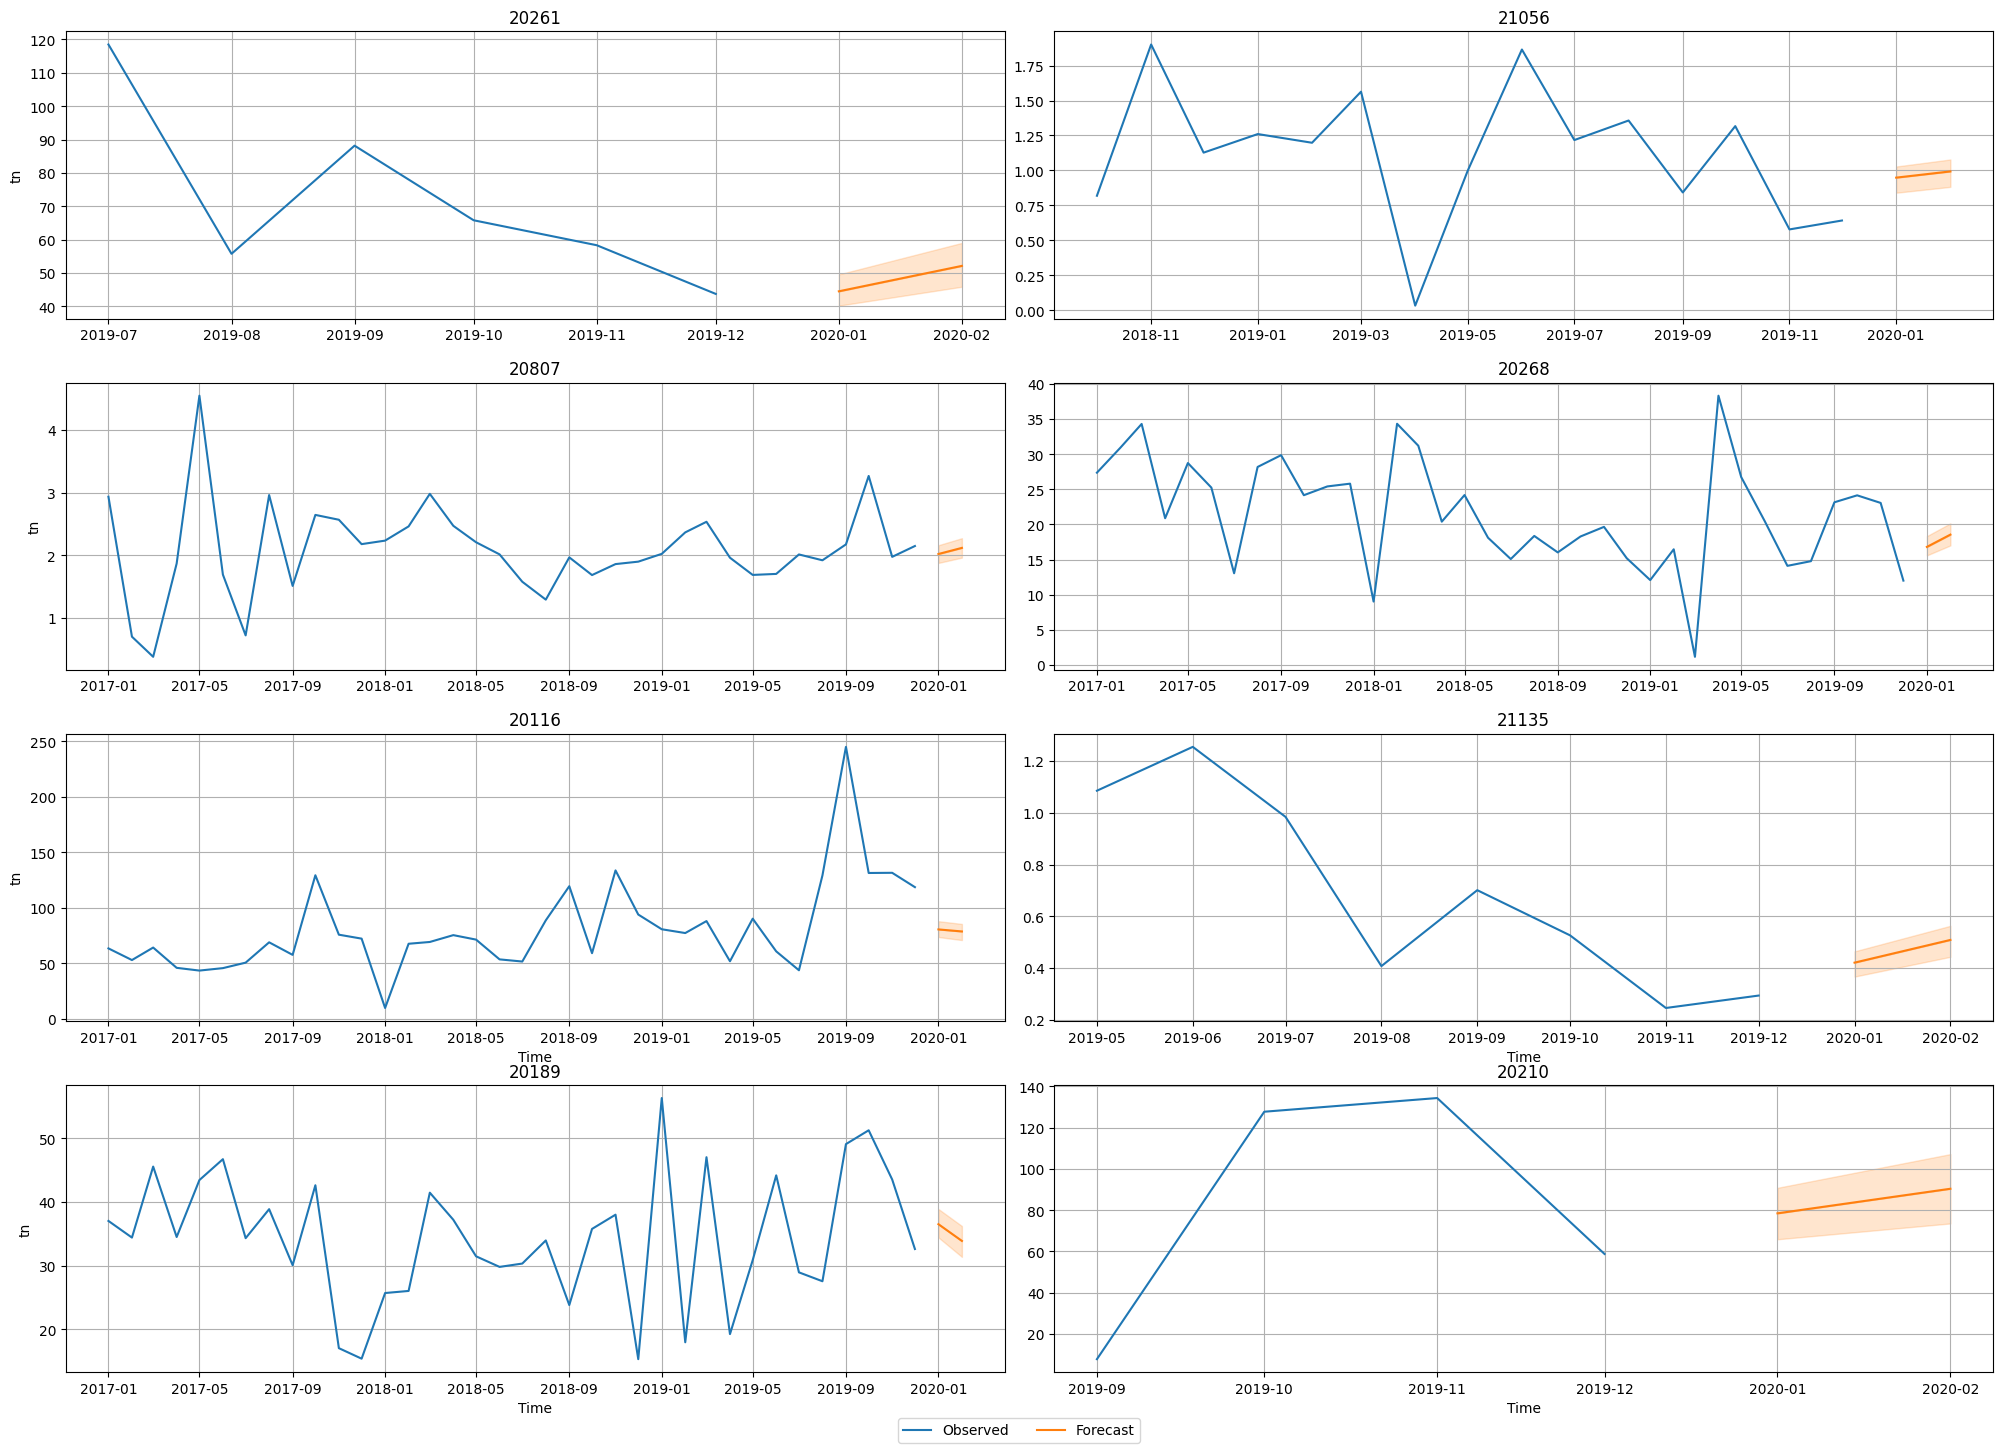

In [103]:
#Graficar
import matplotlib.pyplot as plt
predictor.plot(ts_data, forecast, quantile_levels=[0.40, 0.60], max_history_length=200, max_num_item_ids=8);
plt.show()

In [ ]:
# predicciones en Quantil 40
forecast_04 = forecast['0.4'].reset_index()
print(forecast_04.columns)

resultado_04 = forecast_04[forecast_04['timestamp'] == '2020-02-01']

resultado_04 = resultado_04[['item_id', '0.4']]
resultado_04.columns = ['product_id', 'tn']

resultado_04.to_csv("../output/autogluon/predicciones_auto_numeric_WQL_val3_RF_Q10_04.csv", index=False)
resultado_04.head()

Index(['item_id', 'timestamp', '0.4'], dtype='object')


,product_id,tn
1,20001,1210.373928
3,20002,1017.334237
5,20003,644.723379
7,20004,496.755083
9,20005,478.691428


In [ ]:
# El código toma las predicciones generadas por AutoGluon (almacenadas en el objeto forecast)
# y extrae únicamente la predicción media ('mean') para cada producto (item_id) en febrero 2020.

# 1. Convierte el índice de forecast['mean'] en columnas normales con reset_index().
# 2. Filtra solo las filas donde la columna 'timestamp' es igual a '2020-02-01' (febrero 2020).
# 3. Selecciona solo las columnas 'item_id' y 'mean', que corresponden al identificador del producto y la predicción de toneladas.
# 4. Renombra las columnas a 'product_id' y 'tn' para que sean más descriptivas y compatibles con el resto del flujo de trabajo.

# Así, el DataFrame resultado contiene la predicción de ventas (en toneladas) para cada producto en febrero 2020, listo para guardar o analizar.
# Extraer predicción media y filtrar febrero 2020
forecast_mean = forecast['mean'].reset_index()
print(forecast_mean.columns)

# Tomar solo item_id y la predicción 'mean'
resultado = forecast['mean'].reset_index()[['item_id', 'mean']]
resultado.columns = ['product_id', 'tn']

# Filtrar solo febrero 2020
resultado = forecast['mean'].reset_index()
resultado = resultado[resultado['timestamp'] == '2020-02-01']

# Renombrar columnas
resultado = resultado[['item_id', 'mean']]
resultado.columns = ['product_id', 'tn']

# 💾 7. Guardar archivo
resultado.to_csv("../output/autogluon/predicciones_auto_numeric_WQL_val3_RF_Q10_mean.csv", index=False)
resultado.head()

Index(['item_id', 'timestamp', 'mean'], dtype='object')


,product_id,tn
1,20001,1264.329611
3,20002,1084.552598
5,20003,687.799519
7,20004,531.960844
9,20005,510.876098


In [ ]:
#ensemble de quantiles, mas peso al 05.
#forecast_04 = forecast['0.4'].reset_index()
forecast_05 = forecast['0.5'].reset_index()
forecast_06 = forecast['0.6'].reset_index()

merged_forecast = forecast_04.merge(forecast_05, on=['item_id', 'timestamp']).merge(forecast_06, on=['item_id', 'timestamp'])

merged_forecast['ensemble'] = (merged_forecast['0.4'] * 0.25 + 
                             merged_forecast['0.5'] * 0.5 + 
                             merged_forecast['0.6'] * 0.25)

resultado_ensemble = merged_forecast[merged_forecast['timestamp'] == '2020-02-01']

resultado_ensemble = resultado_ensemble[['item_id', 'ensemble']]
resultado_ensemble.columns = ['product_id', 'tn']

resultado_ensemble.to_csv("../output/autogluon/predicciones_auto_numeric_WQL_val3_RF_Q10_ensamble.csv", index=False)
resultado_ensemble.head()

,product_id,tn
1,20001,1262.027853
3,20002,1077.789005
5,20003,683.146390
7,20004,531.037806
9,20005,511.201748
